In [ ]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 30.9 MB/s eta 0:00:00


In [ ]:
import requests # obs
import csv
import time
import requests
import math
import networkx as nx
from networkx.algorithms import community
from collections import defaultdict
import igraph as ig
from collections import Counter
from math import log
from itertools import islice

In [ ]:
mailto = "{EMAIL}"

In [ ]:
url = "https://api.openalex.org/works"

In [ ]:
DAMPING_FACTOR = 0.85
MAX_ITERATIONS = 100
TOLERANCE = 0.000001


Pre-Code

In [ ]:
def build_citation_matrix(all_results):
  citation_matrix = {}
  works_by_id = {work["id"]: work for work in all_results}

  for work in all_results:
      citation_matrix[work["id"]] = {
          "cnt": 0,
          "works": set(),
          "title": work.get("title"),
          "publication_year": work.get("publication_year"),
          "key_words": {(word["id"], word["display_name"], word["score"]) for word in work.get("keywords", [])},
          "cited_by": set(),  # ДОБАВЛЕНО: кто цитирует эту работу
          "cites": set(work.get("referenced_works", []))  # ДОБАВЛЕНО: кого цитирует эта работа
      }

  # for work in all_results: #ДОБАВЛЕНО: вынес в цикл выше
      citing_work_id = work["id"]
      next_params = {
        "mailto": mailto,
        "filter": f"cited_by:{citing_work_id}",
        "per-page": 100,
        "select": "id",
      }

      response = requests.get(url, params=next_params)
      time.sleep(0.2)
      if response.status_code == 200:
        this_page_results = response.json()['results']
        citation_matrix.get(citing_work_id)['citation_count'] = len(this_page_results)
        citation_matrix.get(citing_work_id)['citing_works'] = {el["id"] for el in this_page_results}
      else:
        print(f"Непредвиденная ошибка {response}")

  print("Обрабатываем связи цитирования...")

  # ДОБАВЛЕНО: Обновляем данные о цитированиях для PageRank
  for work in all_results:
      work_id = work["id"]

      # Заполняем cited_by (кто цитирует эту работу)
      if 'citing_works' in citation_matrix[work_id]:
          for citing_work in citation_matrix[work_id]['citing_works']:
              if citing_work in citation_matrix:
                  citation_matrix[citing_work]['cited_by'].add(work_id)


  print(f"Обработано связей цитирования для {len(all_results)} работ")

  print(citation_matrix.__len__())


  for work_id in citation_matrix:
    citation_matrix[work_id]['citing_works'] = list(citation_matrix[work_id]['citing_works'])

  return citation_matrix

In [ ]:

def build_local_citation_sets(docs):
    keys = set(docs.keys())
    Ccited = {k: set([r for r in docs[k].get("cites", []) if r in keys]) for k in keys}
    Ccite = {k: set([r for r in docs[k].get("cited_by", []) if r in keys]) for k in keys}

    return Ccite, Ccited

def H(x):
    return float(x) if x and x > 0 else float('inf')

def H_in(A, B, Ccite, Ccited):
    if A in Ccited.get(B, set()):
        return H(len(Ccite.get(A, set())))
    if B in Ccited.get(A, set()):
        return H(len(Ccite.get(B, set())))
    return float('inf')

def H_out(A, B, Ccite, Ccited):
    if B in Ccited.get(A, set()):
        return H(len(Ccited.get(A, set())))
    if A in Ccited.get(B, set()):
        return H(len(Ccited.get(B, set())))
    return float('inf')

def calculate_similarity(A, B, Ccite, Ccited):
    NinA = len(Ccite.get(A, set()))
    NinB = len(Ccite.get(B, set()))
    NoutA = len(Ccited.get(A, set()))
    NoutB = len(Ccited.get(B, set()))

    cite_both = len(Ccite.get(A, set()).intersection(Ccite.get(B, set())))
    cited_both = len(Ccited.get(A, set()).intersection(Ccited.get(B, set())))

    denomimator = []
    if NinA > 0:
        denomimator.append(NinA / H(NinA))
    if NinB > 0:
        denomimator.append(NinB / H(NinB))
    if NoutA > 0:
        denomimator.append(NoutA / H(NoutA))
    if NoutB > 0:
        denomimator.append(NoutB / H(NoutB))

    if not denomimator:
        return 0.0

    numer_components = []
    if cite_both > 0:
        numer_components.append(cite_both / H(NinA))
        numer_components.append(cite_both / H(NinB))
    if cited_both > 0:
        numer_components.append(cited_both / H(NoutA))
        numer_components.append(cited_both / H(NoutB))
    numer_components.append(1.0 / H_in(A, B, Ccite, Ccited))
    numer_components.append(1.0 / H_out(A, B, Ccite, Ccited))

    numerator = sum(numer_components)
    denominator = sum(denomimator)

    if denominator == 0:
        return 0.0
    return float(numerator / denominator)

def build_similarity_graph(docs):
    Ccite, Ccited = build_local_citation_sets(docs)
    doc_ids = list(docs.keys())

    G = nx.Graph()
    G.add_nodes_from(doc_ids)

    for i in range(len(doc_ids)):
        for j in range(i+1, len(doc_ids)):
            A = doc_ids[i]
            B = doc_ids[j]

            s = calculate_similarity(A, B, Ccite, Ccited)
            if s > 0:
                G.add_edge(A, B, weight=s)

    return G, Ccite, Ccited

def fast_greedy_clustering_on_Sgraph(G_nx, min_cluster_size=5):
    nodes = list(G_nx.nodes())
    idx = {n:i for i,n in enumerate(nodes)}

    edges = []
    weights = []
    for u, v, data in G_nx.edges(data=True):
        edges.append((idx[u], idx[v]))
        weights.append(float(data.get("weight", 1.0)))

    if len(edges) == 0:
        return {}

    G_ig = ig.Graph(n=len(nodes), edges=edges, directed=False)
    G_ig.es["weight"] = weights

    dendro = G_ig.community_fastgreedy(weights="weight")
    clustering = dendro.as_clustering()

    clusters = {}
    for cid, member_idxs in enumerate(clustering):
        clusters[cid] = [nodes[i] for i in member_idxs if len(member_idxs) >= min_cluster_size]

    return clusters


In [ ]:
def build_clasterization_time_window(start_date, end_date, mailto = "{EMAIL}", theme_index = "T11636"):
  mailto = mailto
  start_date = start_date
  end_date = end_date
  params = {
      "mailto": mailto,
      "filter": f"topics.id:https://openalex.org/{theme_index},from_publication_date:{start_date},to_publication_date:{end_date}",
      "per-page": 100,
  }

  cursor = "*"
  limit=150
  all_results = []
  count_api_queries = 0

  while cursor and (limit is None or len(all_results) < limit):
      params["cursor"] = cursor
      response = requests.get(url, params=params)
      if response.status_code != 200:
          break
      this_page_results = response.json()['results']
      for result in this_page_results:
          all_results.append(result)
          if len(all_results) == limit:
            break
      count_api_queries += 1

      cursor = response.json()['meta']['next_cursor']
  print(f"Done paging through results. We made {count_api_queries} API queries, and retrieved {len(all_results)} results.")


  citation_matrix = build_citation_matrix(all_results)
  works = list(citation_matrix.keys())
  n = len(works)
  work_to_index = {work_id: idx for idx, work_id in enumerate(works)}

  print(f"Вычисляем PageRank для {n} работ...")
  print(f"Параметры: damping={DAMPING_FACTOR}, max_iterations={MAX_ITERATIONS}")

  print("Создаем матрицу переходов...")
  transition_matrix = [[0.0] * n for _ in range(n)]

  for i, work_id in enumerate(works):
      citing_works = citation_matrix[work_id].get('cited_by', set())
      out_links = citation_matrix[work_id].get('cites', set())

      for cited_by in citing_works:
          if cited_by in work_to_index:
              j = work_to_index[cited_by]
              transition_matrix[i][j] += 1

      for cites in out_links:
          if cites in work_to_index:
              j = work_to_index[cites]
              transition_matrix[j][i] += 1

  print("Нормализуем матрицу...")
  for i in range(n):
      row_sum = sum(transition_matrix[i])
      if row_sum > 0:
          for j in range(n):
              transition_matrix[i][j] /= row_sum
      else:
          for j in range(n):
              transition_matrix[i][j] = 1.0 / n

  print("Запускаем итерационный расчет...")
  pagerank = [1.0 / n] * n

  for iteration in range(MAX_ITERATIONS):
      new_pagerank = [0.0] * n

      for j in range(n):
          sum_val = 0.0
          for i in range(n):
              sum_val += transition_matrix[i][j] * pagerank[i]
          new_pagerank[j] = (1 - DAMPING_FACTOR) / n + DAMPING_FACTOR * sum_val

      diff = sum(abs(new_pagerank[i] - pagerank[i]) for i in range(n))
      if diff < TOLERANCE:
          print(f"✓ PageRank сошелся после {iteration + 1} итераций (diff: {diff:.8f})")
          break

      pagerank = new_pagerank

      if iteration % 10 == 0:
          print(f"  Итерация {iteration}: diff = {diff:.6f}")

  print("Сохраняем результаты PageRank...")
  for idx, work_id in enumerate(works):
      citation_matrix[work_id]['pagerank'] = pagerank[idx]

  print("✓ PageRank успешно вычислен!")

  return citation_matrix



In [ ]:
def build_multi_time_citation_graph(time_windows, K=5, min_cluster_size=2):
    """
    Строит временной граф кластеров с направленными ребрами между окнами

    Args:
        time_windows: список дат для временных окон
        K: количество топовых ключевых слов для каждого кластера
        min_cluster_size: минимальный размер кластера для отображения
    """

    time_intervals = list(zip(time_windows[:-1], time_windows[1:]))

    all_clusters_by_window = []
    citation_matrices_by_window = []
    top_keywords_by_cluster = {}  # (window_idx, cluster_id) -> top_k keywords

    print(f"Всего временных окон: {len(time_intervals)}")

    for window_idx, (start_date, end_date) in enumerate(time_intervals):
        print(f"Временное окно {window_idx+1}: {start_date} - {end_date}")

        citation_matrix_for_window = build_clasterization_time_window(start_date, end_date)

        print(f"Количество работ: {len(citation_matrix_for_window)}")

        if len(citation_matrix_for_window) < min_cluster_size:
            print("Мало данных для этого окна, пропускаем...")
            all_clusters_by_window.append({})
            citation_matrices_by_window.append({})
            continue


        sim_G, Ccite, Ccited = build_similarity_graph(citation_matrix_for_window)
        clusters = fast_greedy_clustering_on_Sgraph(sim_G)

        print(f"Найдено кластеров в окне {window_idx+1}: {len(clusters)}")

        all_clusters_by_window.append(clusters)
        citation_matrices_by_window.append(citation_matrix_for_window)

        for cluster_id, members in clusters.items():
            if len(members) >= min_cluster_size:
                all_keywords = []
                for doc_id in members:
                    key_words = citation_matrix_for_window[doc_id].get('key_words', [])
                    all_keywords.extend(key_words)

                top_k = top_k_keywords(all_keywords, K)
                top_keywords_by_cluster[(window_idx, cluster_id)] = top_k

                print(f"\nКластер {cluster_id} (окно {window_idx+1}, размер: {len(members)}):")
                print(f"Топ-{K} ключевых слов:")
                for i, (keyword, score, count) in enumerate(top_k):
                    print(f"  {i+1}. {keyword} (score: {score:.3f}, статей: {count})")


    time_graph = nx.DiGraph()
    for window_idx in range(len(all_clusters_by_window)):
        clusters = all_clusters_by_window[window_idx]
        citation_matrix = citation_matrices_by_window[window_idx]

        for cluster_id, members in clusters.items():
            if len(members) >= min_cluster_size:
                node_uid = f"W{window_idx}_C{cluster_id}"
                total_citations = sum(
                    citation_matrix[doc_id].get('citation_count', 0)
                    for doc_id in members
                )
                top_kw = top_keywords_by_cluster.get((window_idx, cluster_id), [])
                keywords_str = ", ".join([kw[0] for kw in top_kw[:3]])

                time_graph.add_node(node_uid,
                                   cluster_size=len(members),
                                   total_citations=total_citations,
                                   window=window_idx,
                                   original_cluster_id=cluster_id,
                                   keywords=keywords_str,
                                   full_keywords=top_kw)

    for window_idx in range(len(all_clusters_by_window) - 1):
        current_clusters = all_clusters_by_window[window_idx]
        next_clusters = all_clusters_by_window[window_idx + 1]

        next_citation_matrix = citation_matrices_by_window[window_idx+1]

        current_filtered = {cid: members for cid, members in current_clusters.items()
                          if len(members) >= min_cluster_size}
        next_filtered = {cid: members for cid, members in next_clusters.items()
                        if len(members) >= min_cluster_size}

        current_pairs = list(current_filtered.items())
        next_pairs = list(next_filtered.items())

        for i in range(len(current_pairs)):
            for j in range(len(next_pairs)):
                curr_cluster_id, curr_members = current_pairs[i]
                next_cluster_id, next_members = next_pairs[j]

                N_ci = 0

                for doc_p in curr_members:
                    for doc_q in next_members:
                        if doc_q in next_citation_matrix:
                            cites_list = next_citation_matrix[doc_q].get('cites', [])
                            if doc_p in cites_list:
                                N_ci += 1

                p_size = len(curr_members)
                q_size = len(next_members)

                if p_size > 0 and q_size > 0:
                    cluster_similarity = N_ci / (0.5 * (p_size + q_size))
                    print(f"p_size: {p_size}, q_size: {q_size}, N_ci: {N_ci}")

                    if cluster_similarity > 0.0:
                        source_node = f"W{window_idx}_C{curr_cluster_id}"
                        target_node = f"W{window_idx+1}_C{next_cluster_id}"

                        time_graph.add_edge(source_node, target_node,
                                           weight=cluster_similarity,
                                           citation_count=N_ci,
                                           label=f"{cluster_similarity:.3f}",
                                           size_p=p_size,
                                           size_q=q_size)

    return time_graph, all_clusters_by_window, citation_matrices_by_window

In [ ]:
def top_k_keywords(cluster_articles_keywords, k):
    word_stats = defaultdict(lambda: {"total_score": 0.0, "article_count": 0})

    for keyword, keyword_name, score in cluster_articles_keywords:
       key = keyword_name
       word_stats[keyword_name]["total_score"] += score
       word_stats[keyword_name]["article_count"] += 1

    metrics = []
    for keyword, data in word_stats.items():
        avg_score = data['total_score'] / data['article_count']
        score = avg_score * log(1+data['article_count'])
        metrics.append({
            'word': keyword,
            'score': score,
            'avg_score': avg_score,
            'article_count': data['article_count']
        })

    metrics.sort(key=lambda x: (x['article_count'], x['avg_score'], x['score']), reverse=True)

    return [(res['word'], res["score"],res["article_count"]) for res in metrics[:k]]

In [ ]:
def visualize_time_graph(time_graph): #альтернативный метод, чтобы отрисовывать единый граф для всех временных окон
    import matplotlib.pyplot as plt

    # Создаем позиции для узлов (временные окна по горизонтали)
    pos = {}
    node_colors = []
    node_sizes = []

    # Размер узлов пропорционален размеру кластера
    max_cluster_size = max([data.get('cluster_size', 1)
                          for _, data in time_graph.nodes(data=True)])

    for node, data in time_graph.nodes(data=True):
        window = data.get('window', 0)
        cluster_size = data.get('cluster_size', 1)

        # Располагаем окна по горизонтали, кластеры по вертикали
        pos[node] = (window * 2, hash(node) % 100 / 100.0)

        # Цвет в зависимости от окна
        node_colors.append(window)

        # Размер в зависимости от размера кластера
        node_sizes.append(500 + 2000 * (cluster_size / max_cluster_size))

    # Рисуем граф
    plt.figure(figsize=(14, 8))

    # Рисуем узлы
    nx.draw_networkx_nodes(time_graph, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          cmap=plt.cm.viridis,
                          alpha=0.8)




    print(time_graph.edges)

    # nx.draw_networkx_edges(
    #     time_graph, pos,
    #     edgelist=weak_edges,
    #     width=[1.0*5 for el in weak_edges],
    #     style='dashed',
    #     alpha=0.5,
    #     edge_color='gray',
    #     arrows=True,
    #     arrowstyle='-|>',
    #     arrowsize=20
    # )
    # nx.draw_networkx_edges(
    #     time_graph, pos,
    #     edgelist=medium_edges,
    #     width=[1.5*5 for el in medium_edges],
    #     style='solid',
    #     alpha=0.5,
    #     edge_color='blue',
    #     arrows=True,
    #     arrowstyle='-|>',
    #     arrowsize=20
    # )
    # nx.draw_networkx_edges(
    #     time_graph, pos,
    #     edgelist=strong_edges,
    #     width=[3.0*5 for el in strong_edges],
    #     style='solid',
    #     alpha=0.5,
    #     edge_color='red',
    #     arrows=True,
    #     arrowstyle='-|>',
    #     arrowsize=20
    # )

    # Рисуем ребра с толщиной, пропорциональной весу
    edge_widths = [2 + 3 * data.get('weight', 0)
                  for _, _, data in time_graph.edges(data=True)]

    nx.draw_networkx_edges(time_graph, pos,
                          width=edge_widths,
                          alpha=0.5,
                          edge_color='gray',
                          arrows=True,
                          arrowstyle='-|>',
                          arrowsize=20)

    # Рисуем подписи
    labels = {}
    for node, data in time_graph.nodes(data=True):
        window = data.get('window', 0)
        cluster_id = data.get('original_cluster_id', '?')
        size = data.get('cluster_size', 0)
        labels[node] = f"W{window}C{cluster_id}\n({size})"

    nx.draw_networkx_labels(time_graph, pos, labels, font_size=9)

    # Добавляем подписи к ребрам
    edge_labels = {(u, v): f"{d.get('citation_count', 0)}"
                  for u, v, d in time_graph.edges(data=True)}
    nx.draw_networkx_edge_labels(time_graph, pos, edge_labels, font_size=8)

    plt.title("Временная динамика кластеров исследований")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return plt.gcf()

In [ ]:
def visualize_citation_graph(citation_matrix, clusters, G, min_cluster_size=5, window_sim_threshold=(0.0, 0.3, 0.5)): #старый метод общего графа(без ранжирования по окнам)
  cluster_graph = nx.Graph()
  for cluster_id in clusters.keys():
    cluster_graph.add_node(cluster_id)
  cluster_metrics = {}

  top_clusters = {k: v for k, v in clusters.items()
                        if len(v) >= min_cluster_size}

  cluster_pairs = list(top_clusters.keys())



  for cluster_id, doc_ids in top_clusters.items():
    cluster_graph.add_node(cluster_id)
    total_citations = sum(citation_matrix[doc_id].get('citation_count', 0) for doc_id in doc_ids)
    cluster_graph.nodes[cluster_id]["total_citations"] = total_citations

  weak_threshold, medium_threshold, strong_threshold = window_sim_threshold

  for i in range(len(cluster_pairs)):
    for j in range(i + 1, len(cluster_pairs)):
      cluster_p = cluster_pairs[i]
      cluster_q = cluster_pairs[j]
      N_ci = 0
      for doc_p in top_clusters[cluster_p]:
        for doc_q in top_clusters[cluster_q]:
          if doc_q in citation_matrix[doc_p].get('cites', []):
            N_ci += 1
          if doc_p in citation_matrix[doc_q].get('cites', []):
            N_ci += 1
      p_size = len(top_clusters[cluster_p])
      q_size = len(top_clusters[cluster_q])
      cluster_similarity = N_ci/(0.5*(p_size+q_size))



      if cluster_similarity > weak_threshold:

        if cluster_similarity >= strong_threshold:
          edge_type = "strong"
        elif cluster_similarity >= medium_threshold:
          edge_type = "medium"
        elif cluster_similarity >= weak_threshold:
          edge_type = "weak"
        else:
          continue

        edge_attrs = {
            "weight": cluster_similarity,
            "citation_count": N_ci,
            "label": cluster_similarity,
            "size_p": p_size,
            "size_q": q_size,
            "edge_type": edge_type
        }

        cluster_graph.add_edge(cluster_p, cluster_q, **edge_attrs)

  print(clusters)
  return cluster_graph

[('W0_C0', 'W1_C0'), ('W0_C0', 'W1_C7'), ('W0_C0', 'W1_C22'), ('W0_C0', 'W1_C27'), ('W0_C1', 'W1_C0'), ('W0_C1', 'W1_C7'), ('W0_C1', 'W1_C12'), ('W0_C1', 'W1_C22'), ('W0_C1', 'W1_C27'), ('W0_C2', 'W1_C0'), ('W0_C2', 'W1_C7'), ('W0_C2', 'W1_C22'), ('W0_C2', 'W1_C27'), ('W0_C3', 'W1_C0'), ('W0_C3', 'W1_C7'), ('W0_C3', 'W1_C22')]


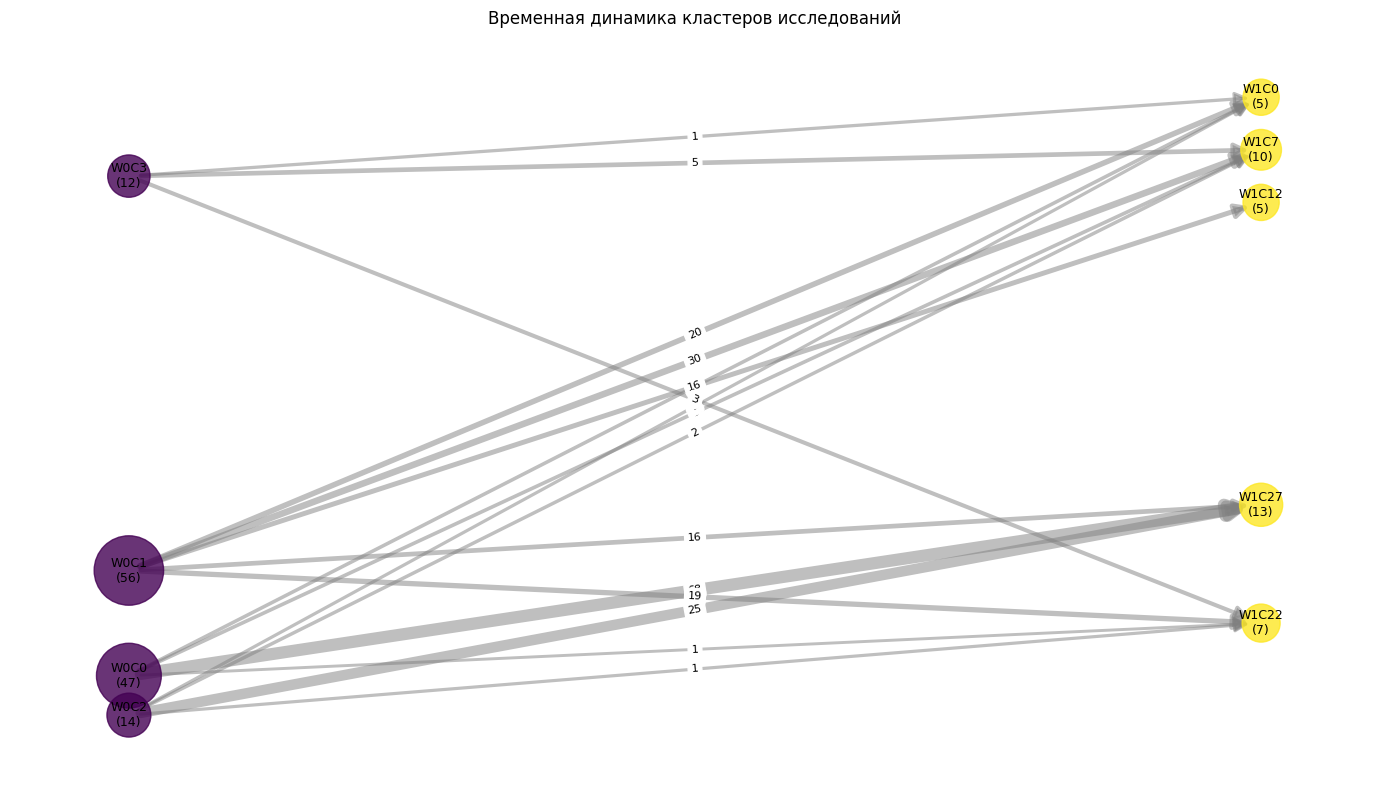

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:

visualize_time_graph(time_graph)

Всего временных окон: 2
Временное окно 1: 2023-01-01 - 2023-12-31
Done paging through results. We made 2 API queries, and retrieved 150 results.
Обрабатываем связи цитирования...
Обработано связей цитирования для 150 работ
150
Вычисляем PageRank для 150 работ...
Параметры: damping=0.85, max_iterations=100
Создаем матрицу переходов...
Нормализуем матрицу...
Запускаем итерационный расчет...
  Итерация 0: diff = 0.637925
  Итерация 10: diff = 0.005786
  Итерация 20: diff = 0.001004
  Итерация 30: diff = 0.000180
  Итерация 40: diff = 0.000033
  Итерация 50: diff = 0.000006
  Итерация 60: diff = 0.000001
✓ PageRank сошелся после 62 итераций (diff: 0.00000094)
Сохраняем результаты PageRank...
✓ PageRank успешно вычислен!
Количество работ: 150
Найдено кластеров в окне 1: 24

Кластер 0 (окно 1, размер: 47):
Топ-5 ключевых слов:
  1. Computer science (score: 1.657, статей: 40)
  2. Psychology (score: 1.241, статей: 34)
  3. Artificial intelligence (score: 1.048, статей: 26)
  4. Engineering (s

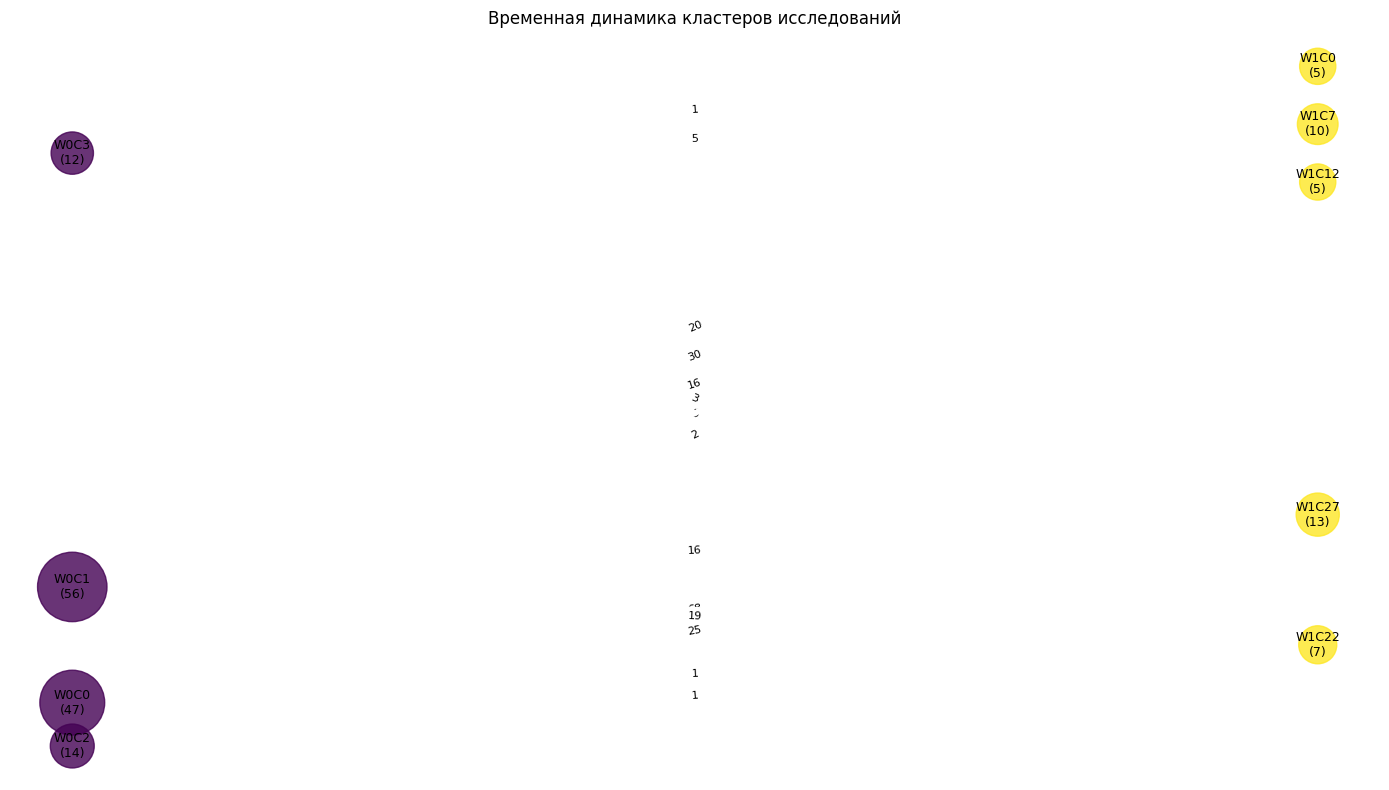

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
time_windows_list = ["2023-01-01", "2023-12-31", "2024-12-31"]


time_graph, all_clusters, citation_matrices = build_multi_time_citation_graph(
        time_windows_list, K=5, min_cluster_size=2
    )

visualize_time_graph(time_graph)